## Note au jury — stratégie NLP & sentiment

Cahier décrivant une stratégie basée sur l'analyse de sentiments appliquée à des news financières. Les notes expliquent les étapes critiques et les hypothèses.


# Trading basé sur NLP et sentiment

On construit un pipeline : ingestion des news, nettoyage, scoring de sentiment, puis liaison avec les rendements pour générer des signaux. L'accent est mis sur la qualité du dataset et la gestion du bruit.


## Parcours méthodologique

- Préparation des données (news, labels, dates).
- Extraction/normalisation du sentiment.
- Liaison avec les rendements (alignement temporel, filtres).
- Génération de signaux et évaluation (PnL, corrélation).


<a id='1'></a>
# 1. Problem Statement

The problem statement is to build a trading strategy that uses NLP to extracts the information inside the news headlines, assigns a sentiment to that and use the sentiments and the information inside the news headlines for a trading strategy.

The data used for this case study will be from three sources:
* **News headlines data compiled from RSS feeds of several news websites**: This news headlines data is complied by different news website and contains the most financially relevant news filtered by human editors. For the purpose of this study, we will only look at the headline, not the details in the story. Another important characteristic of this dataset is that the relevant tickers in the story are extracted. Our dataset contains 82,643 headlines from to 2011-05-02 to 2018-12-28
* **Yahoo finance website for the stock return:** (The return data can be obtained from other website such as yahoo finance)a
* **kaggle**: labelled data of of news sentiments obtained for a classification based sentiment analysis model. This data may not be authentic and is used only for demonstration purpose in this case study. 
* Stock market lexicon created based on stock market conversations in microblogging services. The source of this lexicon is *Oliveira, Nuno, Paulo Cortez, and Nelson Areal. "Stock market sentiment lexicon acquisition using microblogging data and statistical measures." Decision Support Systems 85 (2016): 62-73.*



<a id='1'></a>
# 2. Getting Started- Loading the data and python packages


<a id='2.1'></a>
## 2.1. Loading the python packages

As a first step we check if the additional packages needed are present, if not install them. These are checked separately as they aren't included in requirement.txt as they aren't used for all case studies.

Let us load the libraries

In [1]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

#Run the command python -m spacy download en_core_web_sm to download this
#https://spacy.io/models
import en_core_web_lg
nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from tensorflow.keras.layers import Embedding


# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

#Additional Libraries 
import json  
import zipfile
import os.path
import sys


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/salok1/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/home/salok1/miniconda/envs/dl-gpu-clone/lib/python3.12/site-packages/spacy/util.py:922: UserWarning: [W095] Model 'en_core_web_lg' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.7). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
2025-10-02 01:01:29.616781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-02 01:01:29.670518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This T

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2.2'></a>
## 2.2. Loading the stock price data

The stock price data is loaded in this step from Yahoo Finance in this step. The loaded data is saved in csv for further use.

In [3]:
import pandas as pd
import yfinance as yf

# Définir la période pour récupérer les données
start = '2010-01-01'
end = '2020-12-31'

# Liste des tickers à récupérer
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA','NFLX','ADBE'] # Vous pouvez ajuster cette liste

# Initialiser un DataFrame vide
df_ticker_return = pd.DataFrame()

# Récupérer les données pour chaque ticker
for ticker in tickers:
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start=start, end=end)
        df_ticker_return['ticker'] = ticker
    else:
        data_temp = ticker_yf.history(start=start, end=end)
        data_temp['ticker'] = ticker
        # Utiliser pd.concat() au lieu de .append()
        df_ticker_return = pd.concat([df_ticker_return, data_temp], ignore_index=False)

df_ticker_return.to_csv(r'Data\Step2.2_ReturnData.csv')


Failed to get ticker 'AAPL' reason: Impersonating chrome136 is not supported


ImpersonateError: Impersonating chrome136 is not supported

Let us look at the details of the data

In [33]:
df_ticker_return.head(2)

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,


The data contains the tickers and their return. In this next step, we clean the data make sure that the starting point is 2010 and the NAs in the data are dropped. Let us look at the news data now.

<a id='3'></a>
# 3. Data Preparation

We divide the data preparation into couple of steps as follows:
* Loading and preprocessing the news data
* Preparing the combined data


#### <font color='red'>Note : Step 3.1 to 3.2 might be time consuming. Skip to step 3.3 and load the preprocessed data directly in case you want to avoid these steps. You can also start directly with step 4.4 in case you want to skip the model training and used the sentiments directly for the trading strategy.</font> 

<a id='3.1'></a>
## 3.1 Loading and preprocessing News Data

The news data is downloaded from the News RSS feed and the file is downloaded in the json format and the json files for different dates are kept under a zipped folder. 

Let us see the content of the json file

In [34]:
z = zipfile.ZipFile("Data/Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:500]  
fileDataSample


'li class="n-box-item date-title" data-end="1305172799" data-start="1305086400" data-txt="Tuesday, December 17, 2019">Wednesday, May 11, 2011</li><li class="n-box-item sa-box-item" data-id="76179" data-ts="1305149244"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/CSCO" target="_blank">CSCO</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76179" sasource="on_the_move_news_fidelity" target="_blank">Cisco (NASDAQ:CSCO): Pr'

As we can see that the json format is not suitable for the algorithm. We need to get the news from the jsons and the following function is used for it. Regex becomes the vital part of this step. Regex can find a pattern in the raw, messy text and perform actions accordingly.

In [35]:
#This function performs the json parsing given the 
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return main_tickers, final_headlines



In [36]:
jsonParser(json.loads(fileData))[1][1]



'Cisco Systems (NASDAQ:CSCO) falls further into the red on FQ4 guidance of $0.37-0.39 vs. $0.42 Street consensus. Sales seen flat to +2% vs. 8% Street view. CSCO recently -2.1%.'

As we can see that using the json parser the news headlines are extracted from the complex html format. This format is good enough to be used for further analysis.

Now, we extract the ticker and the headlines from all the json files and put it in a dataframe. 

In [37]:
data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("Data/Raw Headline Data.zip", "r") as z:
    for filename in z.namelist(): 
        #print(filename)
        try:               
            print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data)
                if len(final_headlines) != json_data['count']:
                    continue
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
        except:
            pass



Running Raw Headline Data/2011-05-01.json
Running Raw Headline Data/2011-05-02.json
Running Raw Headline Data/2011-05-03.json
Running Raw Headline Data/2011-05-04.json
Running Raw Headline Data/2011-05-05.json
Running Raw Headline Data/2011-05-06.json
Running Raw Headline Data/2011-05-07.json
Running Raw Headline Data/2011-05-08.json
Running Raw Headline Data/2011-05-09.json
Running Raw Headline Data/2011-05-10.json
Running Raw Headline Data/2011-05-11.json
Running Raw Headline Data/2011-05-12.json
Running Raw Headline Data/2011-05-13.json
Running Raw Headline Data/2011-05-14.json
Running Raw Headline Data/2011-05-15.json
Running Raw Headline Data/2011-05-16.json
Running Raw Headline Data/2011-05-17.json
Running Raw Headline Data/2011-05-18.json
Running Raw Headline Data/2011-05-19.json
Running Raw Headline Data/2011-05-20.json
Running Raw Headline Data/2011-05-21.json
Running Raw Headline Data/2011-05-22.json
Running Raw Headline Data/2011-05-23.json
Running Raw Headline Data/2011-05-

Let us look at the content of the data

In [38]:
data_df_news=pd.concat(data_df_news)
data_df_news.head(2)


,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02


In [39]:
df_ticker_return

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,


As we can see the data has the ticker, headlines and the date which will be used in the next step for combining with the return.

<a id='3.2'></a>
## 3.2 Preparing the combined data

In this step we extract the event return, which is the return that corresponds to
the event. We do this because at times the news is reported late and at other times it is
reported after market close. Having a slightly wider window ensures that we capture
the essence of the event. Event return in defined as follows:
$ R_{t-1} + R_t + R_{t+1} $

Where, $ R_{t-1} $, $ R_{t+1} $ are the return before and after the news data and $ R_{t} $ is the return on
the day of the news (i.e. time t)

In [40]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()
#Computing the event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] + df_ticker_return['ret_curr'].shift(-1) + df_ticker_return['ret_curr'].shift(1)
df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())



Now we have all the data in place we will prepare a combined dataframe which will have the news headlines mapped to the date, event Return and stock ticker. This dataframe will be used for further analysis for sentiment analysis model and for building the trading strategy.

In [41]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','eventRet','Close']]
data_df = data_df.dropna()

In [42]:
data_df.head(2)

,ticker,headline,date,eventRet,Close


Let us save the data in a csv file to be used later, so that the data processing step can be skipped everytime we are looking into analysis. 

In [43]:
data_df.dropna().to_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|', index=False)

<a id='3.3'></a>
## 3.3 Loading the preprocessed data
#### Start from this step in case you dont want to run the previous preprocessing steps

In [44]:
data_df = pd.read_csv(r'Data/Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

In [45]:
print(data_df.shape, data_df.ticker.unique().shape)

(2628, 5) (9,)


In this step, we prepared a clean dataframe that has ticker, headline, event return, return for a given day and future return for 10 unique stock tickers with total 2759 rows of data.

<a id='4'></a>
# 4 Evaluate Models for Sentiment Analysis

In this section we will go through following three different approaches of getting the sentiments for the news which we will use for building the trading strategy.

* Predefined model-TextBlob package
* Tuned Model-Classification algorithms and LSTM
* Model based on financial lexicon

We will also explore the difference between different ways of performing the sentiment analysis. Let us go through the steps. 


#### <font color='red'>Note : The steps 4.1-4.3 are time consuming steps. Skip to step 4.5 to load the pretrained sentiments and use them for further analysis and building trading strategy.</font> 

<a id='4.1'></a>
## 4.1 - Predefined model-TextBlob package

The texblob sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews(source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective). We apply this on all headline articles. Let us compute the sentiment for all the headlines in the data

In [46]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [47]:
TextBlob(text1).sentiment.polarity

0.5

The sentiment polarity is a number between -1 (Very Negative) and +1 (Very Positive). We apply this on all headline we have in the data processed in the previous step. Let us compute the sentiment for all the headlines in the data

In [48]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']]

Let us analyse the scatterplot of the sentiments and the return.

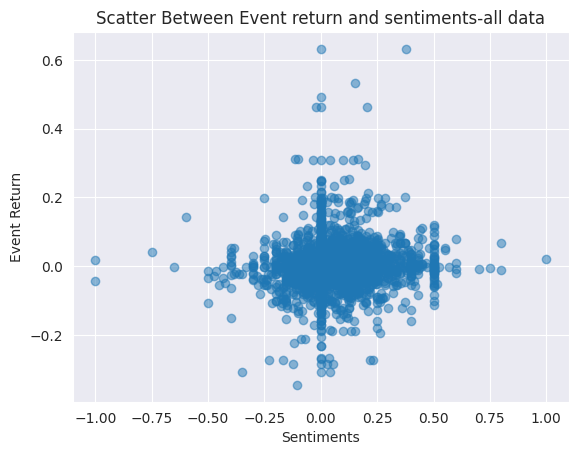

In [49]:
plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [50]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.06784591370367384


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.  

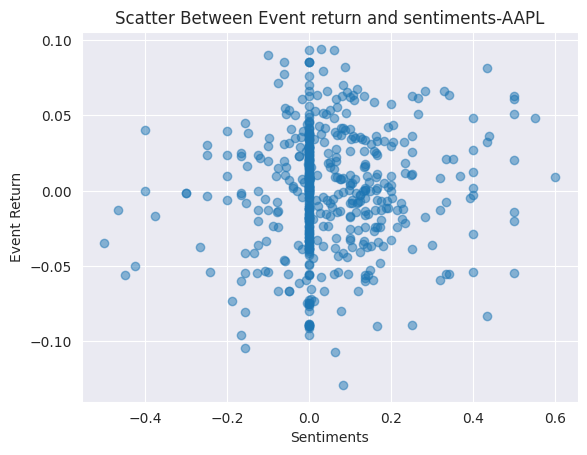

In [51]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0. 

In [52]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment. 

<a id='4.2'></a>
## 4.2 - Supervised Learning-Classification algorithms and LSTM

In this step, we develop customised model for sentiment analysis, based on available labelled data. The label data for this is obtained from kaggle website. Let us look at the data.

In [53]:
sentiments_data = pd.read_csv(r'Data/LabelledNewsData.csv', encoding ="ISO-8859-1")


In [54]:
sentiments_data.head(1)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0


In [55]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


The data has headlines for the news across 30 different stocks, with total 9470 rows, and has sentiments lacelled 0 and 1. The headlines are already in almost cleaned. We perform the classification steps that we discussed in chapter 6, using the classification model development python template discussed in that chapter. 

In order to run a supervised learning model, we first need to convert the news headlines into feature representation. 

In [56]:
import numpy as np

#word-embedding
all_vectors = np.array([np.array([token.vector for token in nlp(s) ]).mean(axis=0)*np.ones((300)) \
                           for s in sentiments_data['headline']])


Now that we have prepared the independent variable we train the classification model in a similar manner as discussed in chapter 6. We first divide the data into training set and test set and futher run the key classification models. 

In [57]:
# split out validation dataset for the end
Y= sentiments_data["sentiment"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

Running all the classification models

In [58]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

LR: 0.872982 (0.006571) 0.893951 0.870468
[[1035  169]
 [ 199 1438]]
KNN: 0.759392 (0.013987) 0.848243 0.763816
[[ 842  279]
 [ 392 1328]]
CART: 0.694075 (0.021521) 0.999698 0.693770
[[ 768  404]
 [ 466 1203]]
SVM: 0.831200 (0.015621) 0.862875 0.833861
[[ 955  193]
 [ 279 1414]]
NN: 0.892288 (0.012106) 0.998642 0.904259
[[1130  168]
 [ 104 1439]]
RF: 0.789109 (0.010524) 0.999698 0.783879
[[ 819  199]
 [ 415 1408]]


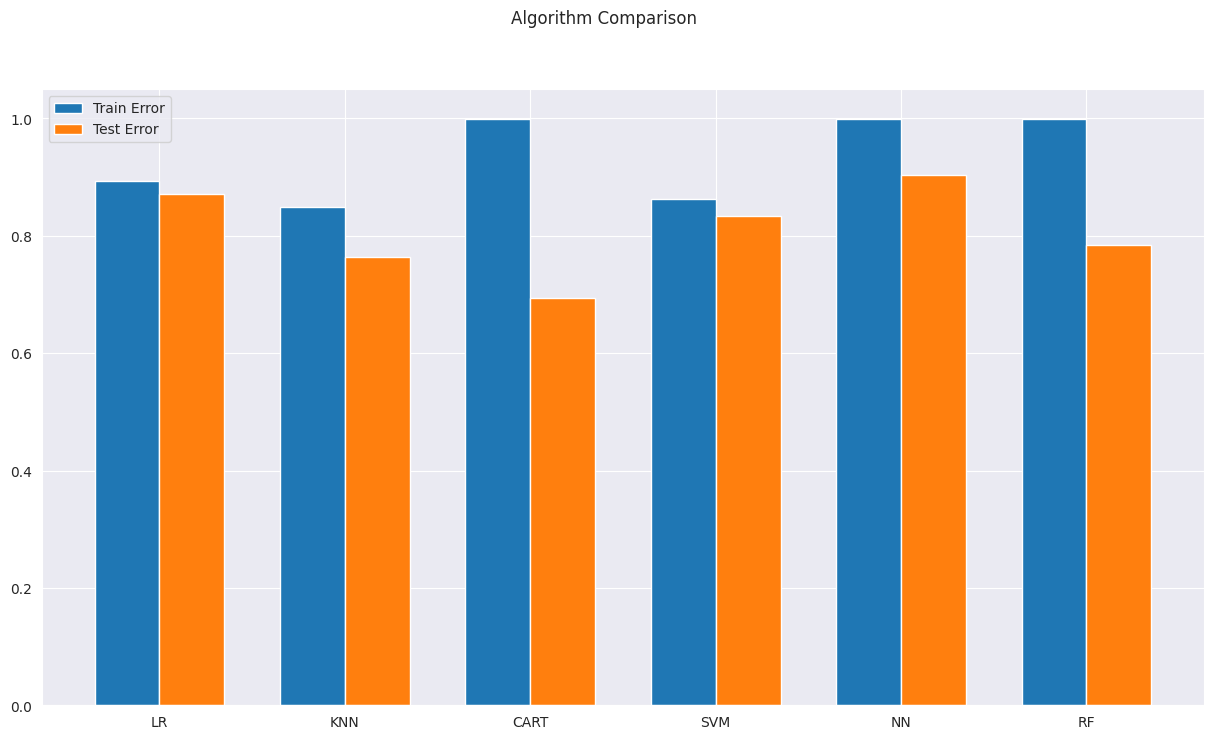

In [59]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As we can see the NN model is the best performer with the a training accuracy of 99% and test accuracy of 93%. The performance of Random forest, SVM and Logistic regression are good as well. CART and KNN don't perform as good as other models. CART has higher overfitting as well. 

### LSTM based model

In the above code snippet, we used the some of the model function which look at the individual works in the sentence for training. However, for NLP, RNN based model are preferred over other machine learning models as RNN stores the information for current feature as well neighboring features for prediction. 

In [60]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

Dividing the data into the training and test set. 

In [61]:
Y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, Y_LSTM, test_size=validation_size, random_state=seed)

In the following code snippet, we used Keras library to build a neural network classifier.

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

class CustomKerasClassifier:
    def __init__(
        self,
        input_length=50,
        vocab_size=20000,
        embedding_dim=300,
        units=64,
        epochs=3,
        batch_size=32,
        verbose=1,
        validation_split=0.4
    ):
        self.input_length = input_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.validation_split = validation_split
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.input_length
        ))
        model.add(LSTM(units=self.units, return_sequences=False))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        return model

    def fit(self, X, y):
        """
        Entraîne le modèle sur les données d'entraînement.

        Args:
            X (array-like): Données d'entrée de forme (n_samples, input_length).
            y (array-like): Étiquettes binaires de forme (n_samples,).

        Returns:
            History: objet History renvoyé par Keras.
        """
        return self.model.fit(
            X,
            y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose,
            validation_split=self.validation_split
        )

    def predict(self, X):
        """
        Prédit les classes (0 ou 1) pour les données fournies.

        Args:
            X (array-like): Données d'entrée de forme (n_samples, input_length).

        Returns:
            ndarray: Prédictions binaires de forme (n_samples,).
        """
        probs = self.model.predict(
            X,
            batch_size=self.batch_size,
            verbose=self.verbose
        )
        # Seuil à 0.5
        return (probs > 0.5).astype('int32')

    def evaluate(self, X, y):
        """
        Évalue le modèle sur un ensemble de test.

        Args:
            X (array-like): Données d'entrée de forme (n_samples, input_length).
            y (array-like): Étiquettes binaires.

        Returns:
            tuple: (loss, accuracy)
        """
        return self.model.evaluate(
            X,
            y,
            batch_size=self.batch_size,
            verbose=self.verbose
        )



In [63]:
model_LSTM = CustomKerasClassifier(epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

# Exemple d'utilisation :
#
# classifier = CustomKerasClassifier(input_length=50, epochs=3, validation_split=0.4)
# history = classifier.fit(X_train_LSTM, Y_train_LSTM)
# y_pred = classifier.predict(X_test_LSTM)
# loss, acc = classifier.evaluate(X_test_LSTM, Y_test_LSTM)


Epoch 1/3


W0000 00:00:1759359069.627645  377205 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8403 - loss: 0.3368 - val_accuracy: 0.9698 - val_loss: 0.0905
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9877 - loss: 0.0411 - val_accuracy: 0.9676 - val_loss: 0.0911
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9965 - loss: 0.0152 - val_accuracy: 0.9706 - val_loss: 0.0830


In [64]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

print(test_result_LSTM)

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.970080957409363


In [65]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Computing the accuracy and confusion metrics. 

In [66]:
print(train_result_LSTM,test_result_LSTM)

0.9874792578066073 0.970080957409363


In [67]:
confusion_matrix(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[1205,   56],
       [  29, 1551]])

In [68]:
train_results.append(train_result_LSTM);test_results.append(test_result_LSTM)

In [69]:
names.append("LSTM")

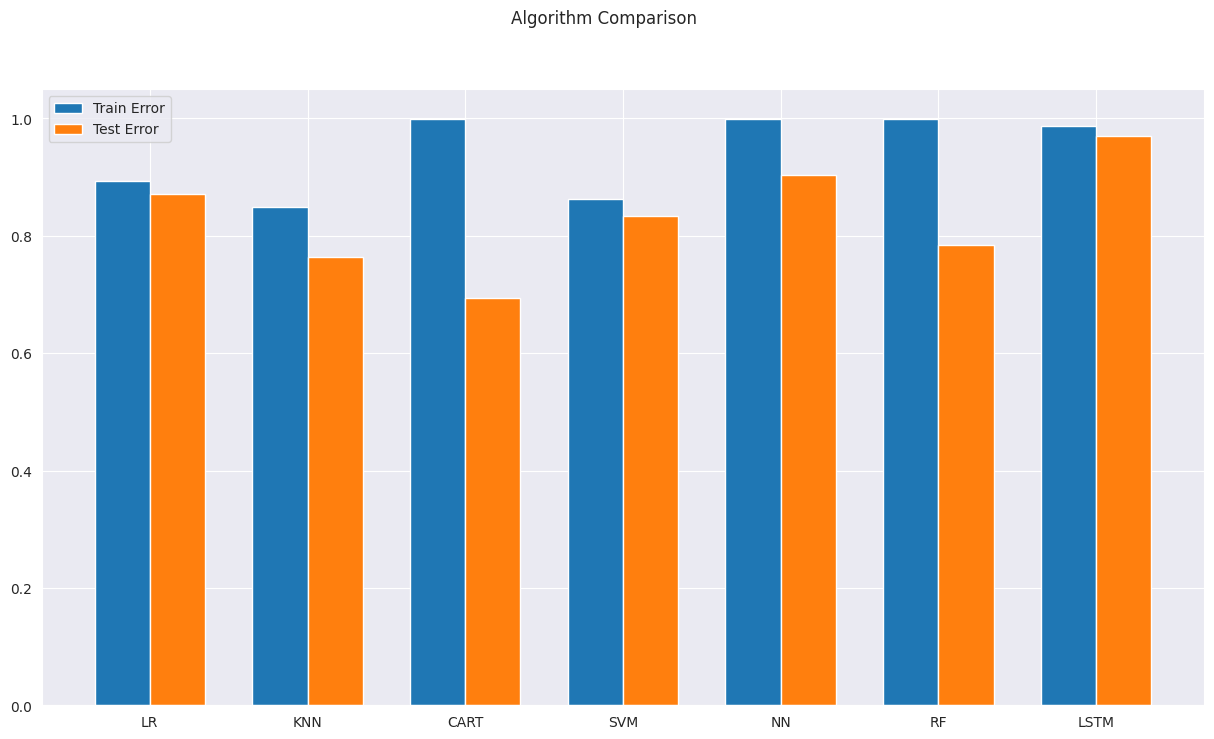

In [70]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As expected, the LSTM model has the best performance in the test set as compared to all other models that we saw before. Let us use LSTM model for the computation of the sentiments in the data. 

In [71]:
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)
print(data_df)

     ticker                                           headline        date  \
0      AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1      NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2      MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3      MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5      AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
...     ...                                                ...         ...   
2632   ADBE  Jefferies rates Adobe (NASDAQ:ADBE) at Buy and...  2019-12-13   
2633   TSLA  Tesla (TSLA +6.4%) is riding higher after Cred...  2019-12-16   
2634   AAPL  Cleveland Research says its checks show strong...  2019-12-16   
2635   TSLA  Tesla (TSLA +3.1%) carved out a new intraday h...  2019-12-18   
2636   TSLA  "Whoa ... the stock is so high lol," tweeted E...  2019-12-23   

      eventRet       Close  sentiment_textblob  
0     0.017650

In [72]:
Y_LSTM = model_LSTM.predict(X_LSTM)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [73]:
data_df['sentiment_LSTM'] = Y_LSTM 

In [74]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.13459407145092986


In [75]:
data_df.head(1)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.01765,10.0595,0.2625,0


<a id='4.3'></a>
## 4.3 - Unsupervised - Model based on financial lexicon

Lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments.
VADER (Valence Aware Dictionary for Entiment Reasoning) is a pre-built sentiment analysis model included in the NLTK package. 

In [76]:
# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('Data/LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

Example of extracting sentiment score for a sentence:

In [77]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [78]:
sia.polarity_scores(text)['compound']

0.4535

Now we extract the sentiment for the entire dataset.

In [79]:
vader_sentiments = np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
vader_sentiments.shape

(2628,)

In [80]:
data_df['sentiment_lex'] = vader_sentiments
print(data_df)

     ticker                                           headline        date  \
0      AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1      NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2      MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3      MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5      AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
...     ...                                                ...         ...   
2632   ADBE  Jefferies rates Adobe (NASDAQ:ADBE) at Buy and...  2019-12-13   
2633   TSLA  Tesla (TSLA +6.4%) is riding higher after Cred...  2019-12-16   
2634   AAPL  Cleveland Research says its checks show strong...  2019-12-16   
2635   TSLA  Tesla (TSLA +3.1%) carved out a new intraday h...  2019-12-18   
2636   TSLA  "Whoa ... the stock is so high lol," tweeted E...  2019-12-23   

      eventRet       Close  sentiment_textblob  sentiment_LSTM 

In [81]:
correlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print(correlation)

0.1707575091453356


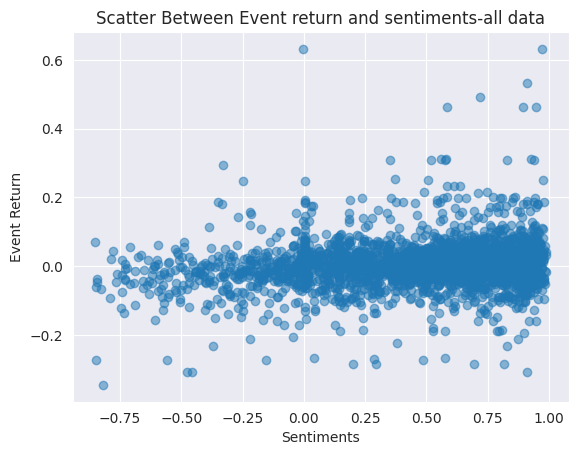

In [82]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We don's see many high returns for lower sentiments, but the data may not be very clear. Let us look at the result for one of the stock tickers. 

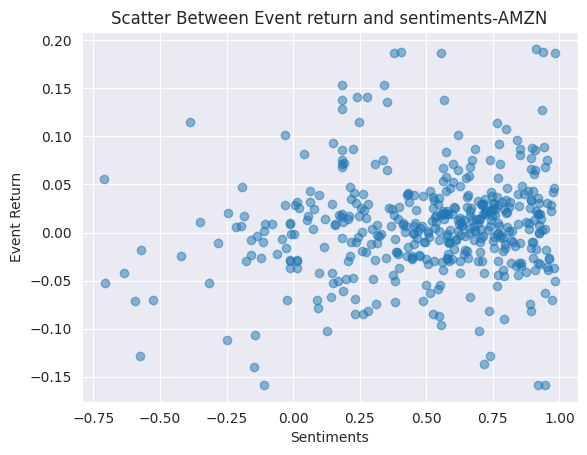

In [83]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We see a positive correlation between the event return and sentiments. We will look deeper into the comparison of different types of the sentiment analysis in the next section.

In [84]:
data_df.to_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|', index=False)
data_df.head(1)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM,sentiment_lex
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.01765,10.0595,0.2625,0,0.2115


<a id='4.4'></a>
## 4.4 Exploratory Data Analysis and comparison

In [85]:
data_df = pd.read_csv(r'Data/Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]
data_df.head(1)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM,sentiment_lex
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.01765,10.0595,0.2625,0,0.2115


Let us look at the sample headlines and the the sentiments from three different methodology, followed by the analysis using visualization. 

In [86]:
data_new_df_stock=data_df[data_df['ticker']== 'GOOG'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(5))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
5,GOOG,"It's been some time coming, but Google (GOOG -1.9%) makes its first trip into the bond market with a planned $3B sale that should be ""scooped up like nobody's business."" The company had $35B in cash and marketable securities at 2010's end, but will pay back short-term borrowings as investment-grade borrowing costs are about the lowest since November.",0.125000,0,0.6199
16,GOOG,"Google (NASDAQ:GOOG) has taken a ""failed approach so far"" to tablet computing, Steve Ballmer (MSFT +2.4%) says - but he thinks the iPad (NASDAQ:AAPL) has turned out all right. The remarks came as Microsoft's CEO laid out the company's issues with Chinese piracy: Its revenue there is 5% of that in the U.S., though PC sales are about equal in the two countries. (Einhorn earlier)",-0.019048,0,0.7054
21,GOOG,"Google (GOOG +1.4%) announces enhancements to search, including voice search on the desktop and image identification, but many investors' eyes are on mobile enhancements with a local focus. Mobile traffic is peaking on weekends and the company says it's critical to get mobile results right the first time. (Q&A live now)",0.195346,1,0.8487
22,GOOG,"Wireless spectrum in the U.S. is so limited - and Americans' appetite for bulky media like video so voracious - that wireless broadband won't be truly able to handle it ""for a long time to come,"" says Motorola Mobility's (MMI +2.3%) Sanjay Jha. Peak speeds of 4G networks rival wireline, but the standard broadband provided to homes by cable companies should continue to dominate.",0.094643,0,0.4556
23,GOOG,"Google (GOOG -2.1%) shares slump to a nine-month low after Raymond James' checks with search engine marketers show less-than-expected paid-search spending. ""U.S. retail paid-search spend is up high-single low-double digits Y/Y but below... expectations of 15-20%."" Shares haven’t closed below $500 since September; they're now at ~$490.",-0.050000,0,0.7142


Looking at one of the headlines, the sentiment from this sentence is positive. 

<Axes: title={'center': 'Correlation Matrix'}>

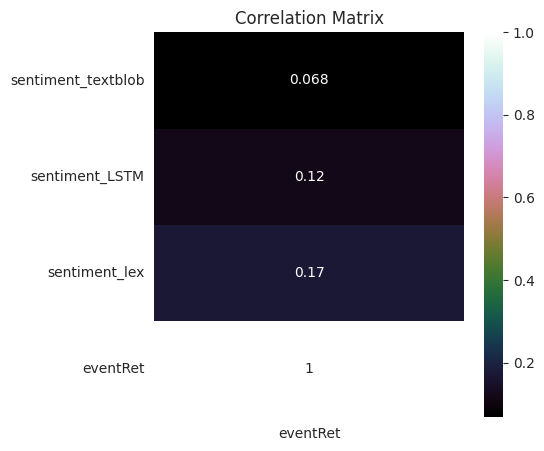

In [87]:
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')

All the sentiments have positive relationship with the return which is intuitive and expected. 

In [88]:
corr_data = []
tickers = data_df['ticker'].unique()
for ticker in tickers:
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_LSTM = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
        #print(ticker,corr_vader, corr_LSTM, corr_textblob)
    else:
        continue

In [89]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.018636,0.129802,0.126934
NFLX,0.104197,0.092005,0.221759
MSFT,-0.027449,0.129157,0.031447
GOOG,0.016635,0.129649,0.209936
JPM,-0.165164,0.191519,0.005866
TSLA,0.120428,0.157544,0.217982
AAPL,0.096950,0.145187,0.228320
WMT,0.174299,0.085351,0.105700
ADBE,0.015741,0.031062,0.114204


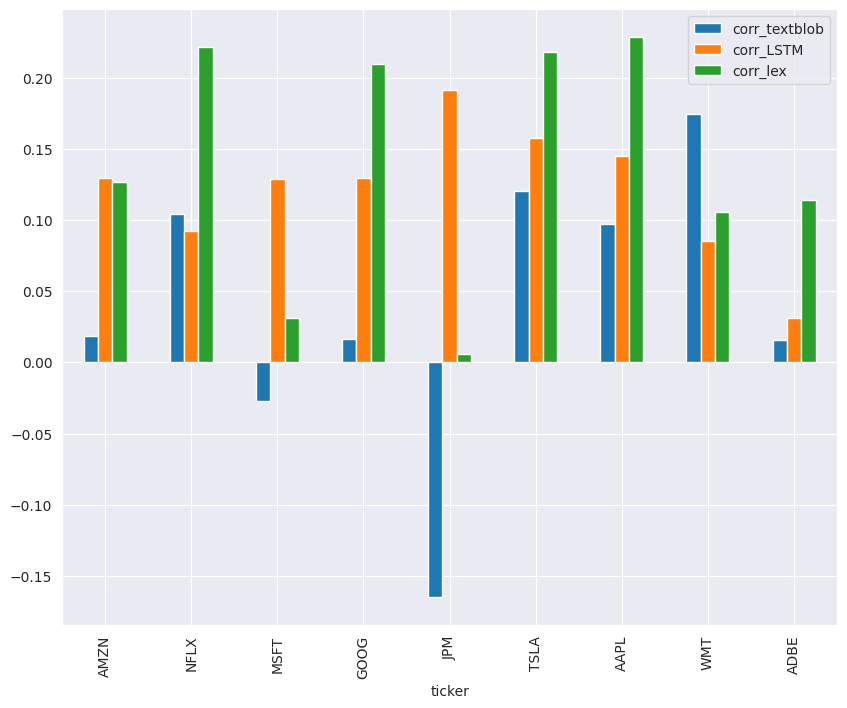

In [90]:
#corr_df.to_csv("correlation.csv")
#tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA']
corr_df.loc[tickers].plot.bar(figsize = (10,8))
plt.show()

Looking at the chart the corrlation from the lexicon methodology is highest across all the stock tickers, which corraborates the conclusion from the previous analysis.

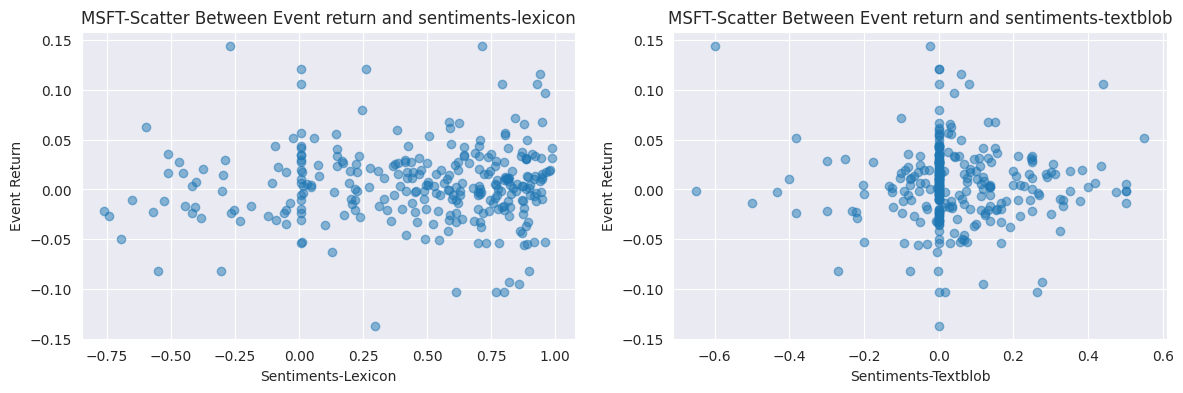

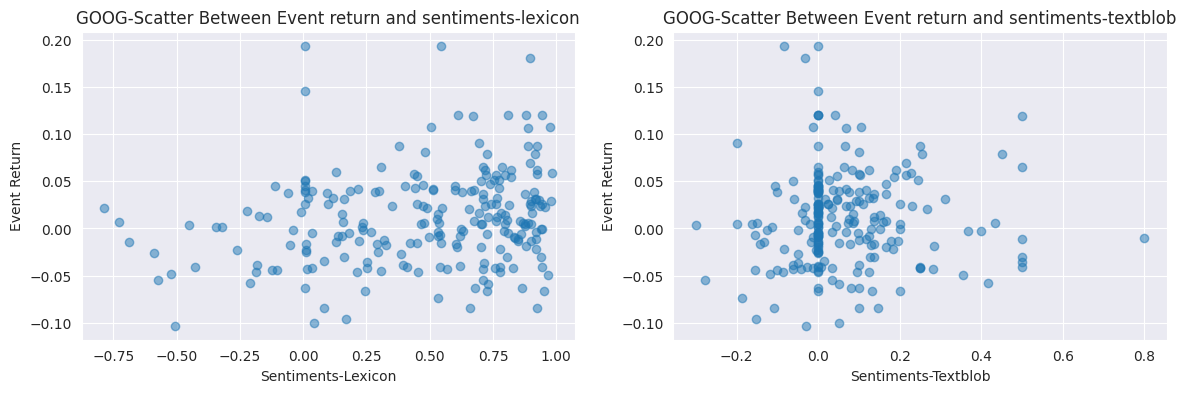

In [91]:
#tickers = corr_df.nlargest(5,'corr_lex').index
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    
    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()
    

The lexicon based sentiments on the left definitely shows a positive relationship between the sentiments and return. We use lexicon based sentiments for the trading strategy in the next step.

<a id='5'></a>
# 5. Model Evaluation- Building a Trading Strategy

The sentiment data can be used in different ways for the trading strategy. Sentiment scores can be used as a directional signal and ideally create a long-short portfolio, by buying the stocks with positive score and selling the stocks with negative score. The sentiments can also be used as additional features over and above other features(such as correlated stocks, technical indicators) in a supervised learning model to predict the price or come up with a trading strategy. 

In the trading strategy in this case study we buy and sell stock as per the current stock sentiments : 
* Buy a stock when the change in sentiment score (Current sentiment score - previous sentiment score) is greater than .5 and sell a stock when the change in sentiment score is less than -.5.
* Additionally, we check for 15 days moving average while buying and selling and buy or sell in a unit of 100. 

Obviusly, there can be many ways to create the trading strategy based in sentiments, by varying the threshold, or changing the number of units based on the initial cash available.

We use lexicon based sentiments for the trading strategy.


<a id='5.1'></a>
## 5.1. Setting up the strategy 
Here we use backtrader which is a Python based API for writing and backtesting trading strategy. . Backtrader allows you to focus on writing reusable trading strategies, indicators and analyzers instead of having to spend time building infrastructure. we have a convenient framework to backtest and write our trading strategy. We used the Quickstart code in the docs (i.e. Refer to https://www.backtrader.com/docu/quickstart/quickstart/) as a base and modified it to include the sentiment scores.

We imlement a simple strategy to buy if the previous day’s sentiment score increases by 0.5 from the last day and sell if it decreases by 0.5.


The following function contains two classes: 
* Sentiment:
* SentimentStrat: The "next" function of this class implements the actual trading strategy. 


In [92]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])

    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    ### Main Strat ###
    def next(self):
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]

        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))
                self.order = self.buy()

        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)



### Function for running the trading strategy

Now, we write a generic function to run the strategy for any stock. We specified the “ticker” stock feeds to be pulled from Yahoo Finance, set an initial amount of $100,000, a fixed size of 100 lots per trade.

In [93]:
def run_strategy(ticker, start, end):
    print(ticker)
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)

    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)
    start = 100000.0
    cerebro.broker.setcash(start)
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)
    plt.rcParams['figure.figsize']=[10,6]
    plt.rcParams["font.size"]="12"
    cerebro.run()
    cerebro.plot(volume=False, iplot=True, plotname= ticker)
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    return float(df_ticker['Close'][0]), (end - start)


<a id='5.2'></a>
## 5.2. Results for Individual Stocks

First running the strategy for google

In [94]:
ticker = 'GOOG'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

Failed to get ticker 'GOOG' reason: Impersonating chrome136 is not supported
$GOOG: possibly delisted; no timezone found


GOOG
Starting Portfolio Value: 100000.00


IndexError: array assignment index out of range

The results show an overall profit of 49719.00. The chart is divided into three panels. 

* Top Panel : Top panel is the cash value observer which as the name implies keeps track of the Cash and total portolio Value (including cash) during the life of the backtesting run. As we can see that we started with 100000.00 and final value at the end is 149719.00 as shown in this panel.

* Second Panel : This panel is Trade Observer which shows, at the end of a trade, the actual Profit and Loss. A trade is defined as opening a position and taking the position back to 0 (directly or crossing over from long to short or short to long). Five out of eight actions of buy and sell are profitable for the strategy. 

* Third Panel : This panel is Buy Sell observer which plots (on top of the prices) where buy and sell operations have taken place. In general we see that (specially around 2018) the buy action takes place when the stock price is increasing and the sell action takes place when the stock price has started declining.   

* Bottom Panel : This panel shows the sentiment score. 

Now we choose one of the days on which buy was triggered and we look at the news on that data and previous day.

In [262]:
ticker = 'GOOG'
GOOG_ticker= data_df[data_df['ticker'].isin([ticker])]
New= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-17']['headline'])
Old= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-16']['headline'])
print("Current News:",New,"\n\n","Previous News:", Old)

Current News: ["Axiom Securities has upgraded Google (GOOG +13.4%, GOOGL +14.8%) to Buy following the company's Q2 beat and investor-pleasing comments about spending discipline, potential capital returns, and YouTube/mobile growth. MKM has launched coverage at Buy, and plenty of other firms have hiked their targets. Google's market cap is now above $450B."] 

 Previous News: ["While Google's (GOOG, GOOGL) Q2 revenue slightly missed estimates when factoring traffic acquisitions costs (TAC), its ex-TAC revenue of $14.35B was slightly above a $14.3B consensus. The reason: TAC fell to 21% of ad revenue from Q1's 22% and Q2 2014's 23%. That also, of course, helped EPS beat estimates.", 'Google (NASDAQ:GOOG): Q2 EPS of $6.99 beats by $0.28.']


Clearly the News on the current day has positive sentiment as compared to the news at the previous day causing the buy to be triggered. Now, we run the strategy for Facebook.

In [263]:
ticker = 'TSLA'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

TSLA
Starting Portfolio Value: 100000.00
2012-03-26, Previous Sentiment 0.30, New Sentiment 0.90 BUY CREATE, 2.49
2012-03-27, BUY EXECUTED, Price: 2.48, Cost: 247.73, Comm 0.00
2012-09-10, Previous Sentiment 0.89, New Sentiment -0.33 SELL CREATE, 1.82
2012-09-11, SELL EXECUTED, Price: 1.85, Cost: 247.73, Comm 0.00
2012-09-11, OPERATION PROFIT, GROSS -62.67, NET -62.67
2012-12-04, Previous Sentiment 0.22, New Sentiment 0.76 BUY CREATE, 2.26
2012-12-05, BUY EXECUTED, Price: 2.25, Cost: 225.47, Comm 0.00
2013-02-21, Previous Sentiment 0.87, New Sentiment 0.04 SELL CREATE, 2.34
2013-02-22, SELL EXECUTED, Price: 2.38, Cost: 225.47, Comm 0.00
2013-02-22, OPERATION PROFIT, GROSS 12.67, NET 12.67
2013-03-25, Previous Sentiment 0.32, New Sentiment 0.87 BUY CREATE, 2.50
2013-03-26, BUY EXECUTED, Price: 2.53, Cost: 253.20, Comm 0.00
2013-09-12, Previous Sentiment 0.94, New Sentiment 0.28 SELL CREATE, 11.00
2013-09-13, SELL EXECUTED, Price: 10.85, Cost: 253.20, Comm 0.00
2013-09-13, OPERATION PROF

(1.871999979019165, 1050.3332614898682)

Top Panel : The CashValue shows overall profit of 8041.00.

Second Panel : A Trade Observer shows that six out of 7 actions are profitable. 

Third Panel : A BuySell observer shows that in general the buy action takes place when the stock price is increasing and the sell action takes place when the stock price has started declining.   

Forth Panel : It shows high number of positive sentiment for the FB around 2013 and 2014 period.

<a id='5.3'></a>
## 5.3. Results for Multiple Stocks

In [264]:
results_tickers = {}
for ticker in tickers:
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

AMZN
Starting Portfolio Value: 100000.00
2013-01-30, Previous Sentiment 0.40, New Sentiment 0.95 BUY CREATE, 13.64
2013-01-31, BUY EXECUTED, Price: 13.55, Cost: 1355.20, Comm 0.00
2013-04-18, Previous Sentiment 0.89, New Sentiment 0.38 SELL CREATE, 12.97
2013-04-19, SELL EXECUTED, Price: 12.91, Cost: 1355.20, Comm 0.00
2013-04-19, OPERATION PROFIT, GROSS -64.40, NET -64.40
2013-10-25, Previous Sentiment 0.15, New Sentiment 0.84 BUY CREATE, 18.17
2013-10-28, BUY EXECUTED, Price: 18.00, Cost: 1799.60, Comm 0.00
2014-02-03, Previous Sentiment 0.56, New Sentiment -0.15 SELL CREATE, 17.31
2014-02-04, SELL EXECUTED, Price: 17.48, Cost: 1799.60, Comm 0.00
2014-02-04, OPERATION PROFIT, GROSS -51.65, NET -51.65
2014-05-20, Previous Sentiment -0.59, New Sentiment 0.08 BUY CREATE, 15.06
2014-05-21, BUY EXECUTED, Price: 15.11, Cost: 1511.05, Comm 0.00
2014-11-05, Previous Sentiment 0.79, New Sentiment 0.02 SELL CREATE, 14.83
2014-11-06, SELL EXECUTED, Price: 14.83, Cost: 1511.05, Comm 0.00
2014-11

In [265]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AMZN,NFLX,MSFT,GOOG,JPM,TSLA,AAPL,WMT,ADBE
PerUnitStartPrice,8.951500,10.320000,21.077839,16.495001,24.135376,1.872000,12.375390,15.257023,28.570000
StrategyProfit,3789.199829,25180.713654,3904.272958,2474.230218,1779.170026,1050.333261,1345.423616,345.768574,17027.000427


The strategy yield an overall profit be for all the stock. Now we run the strategy varying the time period.

<a id='5.4'></a>
## 5.4. Varying the strategy time period

In this step we run the strategy for differnt time periods and look at the results. We first run it for the time period between 2012 and 2014.

In [266]:
results_tickers = {}
for ticker in tickers:
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2014-12-31')

AMZN
Starting Portfolio Value: 100000.00
2013-01-30, Previous Sentiment 0.40, New Sentiment 0.95 BUY CREATE, 13.64
2013-01-31, BUY EXECUTED, Price: 13.55, Cost: 1355.20, Comm 0.00
2013-04-18, Previous Sentiment 0.89, New Sentiment 0.38 SELL CREATE, 12.97
2013-04-19, SELL EXECUTED, Price: 12.91, Cost: 1355.20, Comm 0.00
2013-04-19, OPERATION PROFIT, GROSS -64.40, NET -64.40
2013-10-25, Previous Sentiment 0.15, New Sentiment 0.84 BUY CREATE, 18.17
2013-10-28, BUY EXECUTED, Price: 18.00, Cost: 1799.60, Comm 0.00
2014-02-03, Previous Sentiment 0.56, New Sentiment -0.15 SELL CREATE, 17.31
2014-02-04, SELL EXECUTED, Price: 17.48, Cost: 1799.60, Comm 0.00
2014-02-04, OPERATION PROFIT, GROSS -51.65, NET -51.65
2014-05-20, Previous Sentiment -0.59, New Sentiment 0.08 BUY CREATE, 15.06
2014-05-21, BUY EXECUTED, Price: 15.11, Cost: 1511.05, Comm 0.00
2014-11-05, Previous Sentiment 0.79, New Sentiment 0.02 SELL CREATE, 14.83
2014-11-06, SELL EXECUTED, Price: 14.83, Cost: 1511.05, Comm 0.00
2014-11

In [267]:

index = ["StockPriceBeginning", "StrategyProfit"]
df = pd.DataFrame.from_dict(results_tickers, orient='index')

The strategy yield an overall profit for all the stocks except two. Now we run the strategy between 2016 and 2018. 

In [268]:
results_tickers = {}
for ticker in tickers:
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2016-01-01', end = '2018-12-31')

AMZN
Starting Portfolio Value: 100000.00
2016-02-29, Previous Sentiment 0.02, New Sentiment 0.88 BUY CREATE, 27.63
2016-03-01, BUY EXECUTED, Price: 27.81, Cost: 2781.45, Comm 0.00
2016-04-28, Previous Sentiment 0.96, New Sentiment 0.31 SELL CREATE, 30.10
2016-04-29, SELL EXECUTED, Price: 33.30, Cost: 2781.45, Comm 0.00
2016-04-29, OPERATION PROFIT, GROSS 548.55, NET 548.55
2016-05-10, Previous Sentiment 0.02, New Sentiment 0.57 BUY CREATE, 35.15
2016-05-11, BUY EXECUTED, Price: 35.29, Cost: 3528.95, Comm 0.00
2016-06-15, Previous Sentiment 0.71, New Sentiment 0.07 SELL CREATE, 35.71
2016-06-16, SELL EXECUTED, Price: 35.60, Cost: 3528.95, Comm 0.00
2016-06-16, OPERATION PROFIT, GROSS 31.30, NET 31.30
2016-07-13, Previous Sentiment 0.07, New Sentiment 0.60 BUY CREATE, 37.13
2016-07-14, BUY EXECUTED, Price: 37.44, Cost: 3744.30, Comm 0.00
2016-07-26, Previous Sentiment 0.46, New Sentiment -0.28 SELL CREATE, 36.78
2016-07-27, SELL EXECUTED, Price: 36.90, Cost: 3744.30, Comm 0.00
2016-07-27

In [269]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AMZN,NFLX,MSFT,GOOG,JPM,TSLA,AAPL,WMT,ADBE
PerUnitStartPrice,31.849501,109.959999,48.240692,36.917141,49.342438,14.894000,23.834383,17.191143,91.970001
StrategyProfit,2393.149757,25019.999695,3189.654596,1564.091281,0.000000,725.733185,-63.182115,191.331898,12551.000214


We see a good performance of the sentiment based strategy across all the stocks except AAPL and we can conclude that our sentiment based strategy performs quite well on different time period. The strategy can be further be tweaked to modify the threshold, order size. Additional metrics such as sharpe ratio and maximum drawdown can also be used to understand the performance of the stratefy. The sentiments can also be used along with the other features such as correlated variables and technical indicators for prediction.   

## Conclusion et limites

La stratégie illustre le potentiel des signaux NLP mais reste sensible au biais de données et au décalage temporel. Pour renforcer la robustesse : meilleures embeddings, vérification de la causalité, et backtests avec coûts de transaction.
